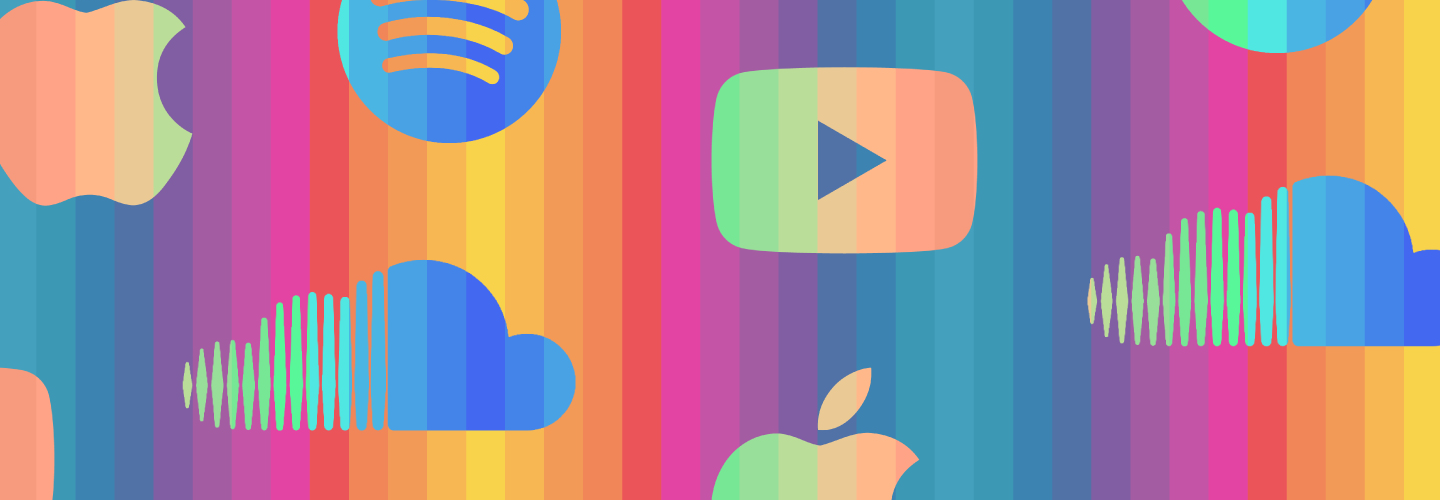 

# Music Throughout the Decades: An Analysis

##  Sarah Flores & Premvanti Patel, UMD CMSC320, Fall 2020 

## Table of Contents:
1. Introduction: What Are We Doing? <br>
2. Data Collection & Processing <br>
    A. Downloading the Billboard Top 100 Data <br>
    B. Preprocessing the DataFrames: Merging, Cleaning, and More! <br>
3. Exploratory Data Analysis <br>
    A. Acoustic Features <br>
    B. Sentiment Analysis <br>
4. Machine Learning: Predicting the Patterns
5. Just For Fun <br>
    A. Visualizing Lyrics <br>
    B. Word Clouds <br>
6. Insights and Conclusions

## 1. Introduction: What Are We Doing?
It's no secret that over the past few decades, people's taste in music has evolved greatly. With this project, we want to explore those changes quantitatively, and more deeply than just finding the most popular genre. There were a few criteria we had to consider in this: how to find the most popular songs, and how exactly to put numbers to music.

After some searching, we found a [database](https://data.world/kcmillersean/billboard-hot-100-1958-2017) that would serve our purposes perfectly. It combined the Billboard Top 100 weekly singles from 1958 to 2019, as well as each singles corresponding acoustic features from Spotify.

The Billboard Top 100 needs no explanation, but Spotify's acoustic features do. In 2015, [Spotify bought a small company named The Echo Nest](https://www.musicbusinessworldwide.com/spotify-acquired-echo-nest-just-e50m/), who had designed an algorithm that classified songs into numerical acoustic features. These features include some obvious ones, such as key and time signature, but also more nuanced fields such as acousticness, danceability, and energy. More information about these features (including a full spec by Spotify) can be found below.

To challenge ourselves and deepen the analysis, we decided to analyze the sentiment of the lyrics of a few of the most popular songs from 1958 to 2019.  With this, we'll also be able to cross-check this against the acoustic features in the database and see if we can find some patterns between the two that maybe even span across time.

Here is a list of the Python packages we needed for this project.
1. [Numpy](https://numpy.org/doc/stable/reference/index.html)
2. [Pandas](https://pandas.pydata.org/docs/reference/index.html)
3. [LyricsGenius](https://github.com/johnwmillr/LyricsGenius#usage)
4. [Datetime](https://docs.python.org/3/library/datetime.html)
5. [Seaborn](https://seaborn.pydata.org/tutorial.html)
6. [VADER](https://github.com/cjhutto/vaderSentiment)
7. [WordCloud](https://pypi.org/project/wordcloud/)

## 2. Data Collection & Processing 

### 2A. Downloading the Billboard Top 100 Data

As mentioned above, we are using databases with Billboards top 100 weekly songs created by <a href="https://data.world/kcmillersean/billboard-hot-100-1958-2017">Sean Miller</a>. All of the libraries necessary to complete this tutorial are imported/installed below. 

In [1]:
# general
import numpy as np
import pandas as pd
import datetime
import re

# plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# scraping lyrics 
!pip install lyricsgenius
import lyricsgenius

# sentiment analysis
!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# machine learning & regression
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

# wordcloud libraries 
!pip install wordcloud
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import warnings
warnings.filterwarnings("ignore")

     |████████████████████████████████| 46 kB 969 kB/s eta 0:00:01
     |████████████████████████████████| 125 kB 1.8 MB/s eta 0:00:01
     |████████████████████████████████| 371 kB 1.7 MB/s eta 0:00:01


As with every good data science project, we'll start by reading our CSV files into DataFrames.

In [2]:
# read into dataframes
features_df = pd.read_csv('Hot 100 Audio Features.csv')
ranks_df = pd.read_csv('Hot Stuff.csv')

# make copies to manipulate
features = features_df.copy(deep=True)
ranks = ranks_df.copy(deep=True)

In the Ranks dataset shown below, there are 10 columns. They tell us how a song ranked in comparison to other songs that year. The attributes provided broadly include three types of information:
1. Song information: the name and performer of the song
2. Charts information: data about when and where the song was on the charts
3. Dataset information: the billboard.com URL, and a SongID specific to the dataset.

In [3]:
ranks.head(3)

,url,WeekID,Week Position,Song,Performer,SongID,Instance,Previous Week Position,Peak Position,Weeks on Chart
0,http://www.billboard.com/charts/hot-100/1958-0...,8/2/1958,1,Poor Little Fool,Ricky Nelson,Poor Little FoolRicky Nelson,1,NaN,1,1
1,http://www.billboard.com/charts/hot-100/1995-1...,12/2/1995,1,One Sweet Day,Mariah Carey & Boyz II Men,One Sweet DayMariah Carey & Boyz II Men,1,NaN,1,1
2,http://www.billboard.com/charts/hot-100/1997-1...,10/11/1997,1,Candle In The Wind 1997/Something About The Wa...,Elton John,Candle In The Wind 1997/Something About The Wa...,1,NaN,1,1


In the Features dataset shown below, we have 22 columns. The first 10 columns provide basic information for each song, like its title and performer. In addition, it also includes Spotify-specific details like Track ID and popularity. The SongID, Song, and Perfomer columns are repeated from the Ranks dataset, which makes them important for connecting the Rank and Features DataFrames. The remaining 12 columns describe the acoustic features of each song. To learn more about what each acoustic feature signifies, check out this <a href="https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/">spec</a> created by Spotify. 

In [4]:
features.head(3)

,SongID,Performer,Song,spotify_genre,spotify_track_id,spotify_track_preview_url,spotify_track_album,spotify_track_explicit,spotify_track_duration_ms,spotify_track_popularity,...,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,"AdictoTainy, Anuel AA & Ozuna","Tainy, Anuel AA & Ozuna",Adicto,['pop reggaeton'],3jbT1Y5MoPwEIpZndDDwVq,NaN,Adicto (with Anuel AA & Ozuna),False,270740.0,91.0,...,10.0,-4.803,0.0,0.0735,0.017,0.000016,0.179,0.623,80.002,4.0
1,The Ones That Didn't Make It Back HomeJustin M...,Justin Moore,The Ones That Didn't Make It Back Home,"['arkansas country', 'contemporary country', '...",NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ShallowLady Gaga & Bradley Cooper,Lady Gaga & Bradley Cooper,Shallow,"['dance pop', 'pop']",2VxeLyX666F8uXCJ0dZF8B,NaN,A Star Is Born Soundtrack,False,215733.0,88.0,...,7.0,-6.362,1.0,0.0308,0.371,0.000000,0.231,0.323,95.799,4.0


### 2B. Preprocessing the DataFrames: Merging, Cleaning, and More!
You might see this as the most boring part of data science, but it's a necessary evil, and extremely important for the rest of the process.  We'll start by merging the Ranks and Features dataframes together on the SongID column. We only want to analyze songs that are present in both dataframes so we will be performing an inner join.

In [5]:
songs = pd.merge(ranks, features, on='SongID', how='inner')
songs.head(3)

,url,WeekID,Week Position,Song_x,Performer_x,SongID,Instance,Previous Week Position,Peak Position,Weeks on Chart,...,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,https://www.billboard.com/charts/hot-100/2019-...,2/2/2019,1,7 Rings,Ariana Grande,7 RingsAriana Grande,1,NaN,1,1,...,1.0,-10.732,0.0,0.334,0.592,0.0,0.0881,0.327,140.048,4.0
1,https://www.billboard.com/charts/hot-100/2019-...,5/25/2019,11,7 Rings,Ariana Grande,7 RingsAriana Grande,1,10.0,1,17,...,1.0,-10.732,0.0,0.334,0.592,0.0,0.0881,0.327,140.048,4.0
2,https://www.billboard.com/charts/hot-100/2019-...,4/20/2019,4,7 Rings,Ariana Grande,7 RingsAriana Grande,1,3.0,1,12,...,1.0,-10.732,0.0,0.334,0.592,0.0,0.0881,0.327,140.048,4.0


This table is simply massive and very clumsy, so we need to do a fair amount of dropping rows and columns. We'll drop any duplicate columns and columns not relevant to our analysis. Additionally, we only want to consider unique, complete rows with no NaN values. 

In [6]:
# remove columns that we won't use 
cols_remove = ['url', 'Performer_y', 'Song_y', 'Weeks on Chart', 'Peak Position', \
               'Previous Week Position', 'Instance', 'spotify_track_id', \
               'spotify_track_preview_url', 'spotify_track_album', \
               'spotify_track_explicit', 'spotify_track_duration_ms' \
              ]
songs.drop(cols_remove, axis = 1, inplace=True)

# rename columns
songs.rename(columns={'Performer_x': 'Performer', 'Song_x': 'Song', 'Week Position': 'Rank'}, inplace=True)

# remove rows with duplicate SongIDs and rows containing NaN 
songs = songs.drop_duplicates(subset='SongID', keep='first')
songs = songs.dropna()

Now, we want to encode the weekID as Datetime objects, which lets us to sort and subdivide our DataFrame more easily later on. For convenience of visualization, we have a year column in addition to a complete Date.

In [7]:
# append new columns
dt = []
years = []
for row_index, row in songs.iterrows():
    temp = datetime.datetime.strptime(songs.at[row_index, 'WeekID'], '%m/%d/%Y')
    dt.append(temp)
    years.append(temp.year)
songs['Datetime'] = dt
songs['Year'] = years

# we can drop the weekID column now
songs.drop('WeekID', axis = 1, inplace=True)

# sort and reset
songs = songs.sort_values(by=['Datetime', 'Rank'])
songs.reset_index(drop=True, inplace=True)

The complete DataFrame after merging and preprocessing:

In [8]:
songs.head(3)

,Rank,Song,Performer,SongID,spotify_genre,spotify_track_popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,Datetime,Year
0,5,When,Kalin Twins,WhenKalin Twins,"['doo-wop', 'rock-and-roll']",20.0,0.646,0.582,6.0,-12.679,1.0,0.0297,0.168,0.000005,0.976,0.963,96.490,4.0,1958-08-02,1958
1,7,Yakety Yak,The Coasters,Yakety YakThe Coasters,"['brill building pop', 'bubblegum pop', 'doo-w...",56.0,0.715,0.669,7.0,-9.491,1.0,0.1280,0.705,0.000732,0.044,0.976,120.789,4.0,1958-08-02,1958
2,8,My True Love,Jack Scott,My True LoveJack Scott,"['brill building pop', 'deep adult standards',...",26.0,0.548,0.253,4.0,-11.387,1.0,0.0279,0.871,0.000099,0.138,0.238,68.184,3.0,1958-08-02,1958


## 3. Exploratory Data Analysis

### 3A: Acoustic Features

Before we start considering any one feature or a subset of our data, we need an idea of some of the trends in the data as a whole. Spotify's acoustic features are a perfect place to start.

We'll examine the following features for relationships to year: acousticness, danceability, energy, instrumentalness, liveness, loudness, speechiness, valence, and tempo. Each year's data is calculated by taking the mean over all the songs for that year.

Note that the key, mode and time signature are excluded here. Key and mode are categorical variables, and time signatures are ratios, so taking the mean of those simply makes no sense in this context. 

For a reminder on what each of the the acoustic features means, check out this [page.](https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/)

In [9]:
# find the average of each feature per year
df = songs.copy()

acoustic_features = ['danceability','energy', 'key', 'loudness',
                     'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
                     'valence', 'tempo', 'time_signature']

feature_averages = df.groupby(["Year"])[acoustic_features].mean()
feature_averages.reset_index(inplace=True)

feature_averages.head(3)

,Year,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,1958,0.545568,0.481923,5.187793,-10.630939,0.863850,0.054967,0.692187,0.054903,0.201030,0.678357,113.433728,3.727700
1,1959,0.522213,0.474698,4.964481,-11.236795,0.846995,0.058178,0.667785,0.063212,0.187984,0.655242,117.028060,3.795082
2,1960,0.509966,0.448055,5.106796,-11.003825,0.864078,0.048328,0.671454,0.069289,0.210367,0.634000,116.993687,3.762136


Let's go ahead and plot these values, since the raw numbers don't mean much to the human eye.

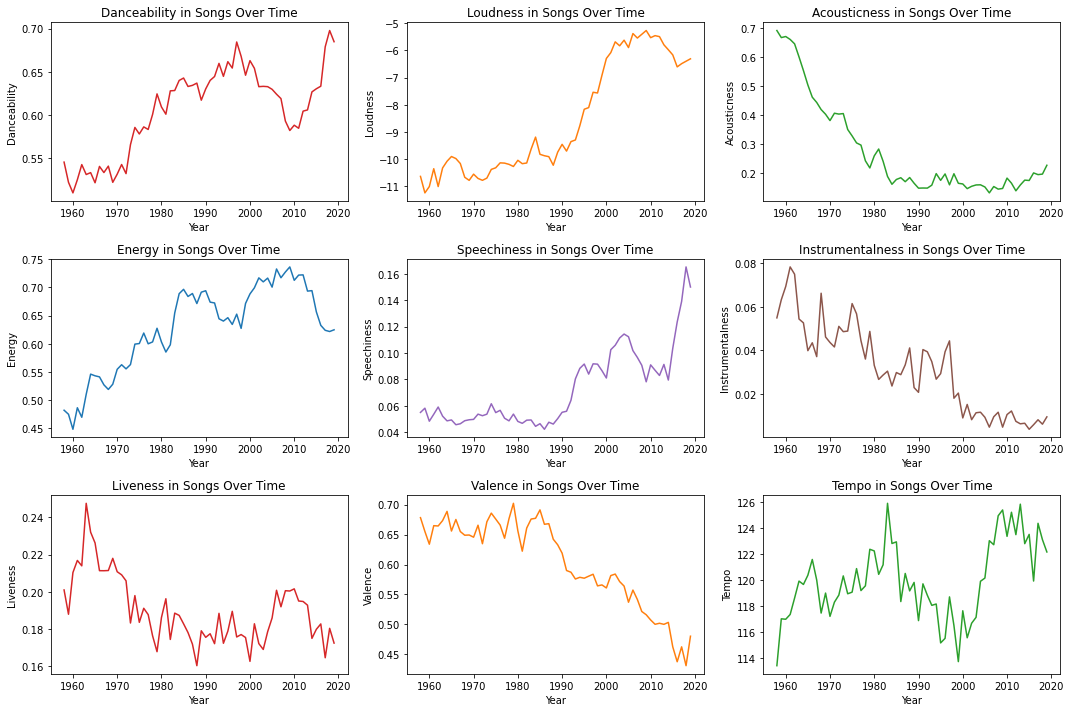

In [10]:
# Generate Plots
fig, axs = plt.subplots(3, 3, figsize=(15,10))

x = feature_averages['Year']

# Plot Danceability
axs[0, 0].plot(x, feature_averages['danceability'],  'tab:red')
axs[0, 0].set_title("Danceability in Songs Over Time")
axs[0, 0].set(ylabel='Danceability')

# Plot Loudness
axs[0, 1].plot(x, feature_averages['loudness'], 'tab:orange')
axs[0, 1].set_title("Loudness in Songs Over Time")
axs[0, 1].set(ylabel='Loudness')

# Plot Acousticness
axs[0, 2].plot(x, feature_averages['acousticness'], 'tab:green')
axs[0, 2].set_title("Acousticness in Songs Over Time")
axs[0, 2].set(ylabel='Acousticness')

# Plot Energy
axs[1, 0].plot(x, feature_averages['energy'], 'tab:blue')
axs[1, 0].set_title("Energy in Songs Over Time")
axs[1, 0].set(ylabel='Energy')

# Plot Speechiness 
axs[1, 1].plot(x, feature_averages['speechiness'], 'tab:purple')
axs[1, 1].set_title("Speechiness in Songs Over Time")
axs[1, 1].set(ylabel='Speechiness')

# Plot Instrumentalness
axs[1, 2].plot(x, feature_averages['instrumentalness'], 'tab:brown')
axs[1, 2].set_title("Instrumentalness in Songs Over Time")
axs[1, 2].set(ylabel='Instrumentalness')

# Plot Liveness
axs[2, 0].plot(x, feature_averages['liveness'], 'tab:red')
axs[2, 0].set_title("Liveness in Songs Over Time")
axs[2, 0].set(ylabel='Liveness')

# Plot Valence
axs[2, 1].plot(x, feature_averages['valence'], 'tab:orange')
axs[2, 1].set_title("Valence in Songs Over Time")
axs[2, 1].set(ylabel='Valence')

# Plot Tempo
axs[2, 2].plot(x, feature_averages['tempo'], 'tab:green')
axs[2, 2].set_title("Tempo in Songs Over Time")
axs[2, 2].set(ylabel='Tempo')

# Set x axis labels to Year
for ax in axs.flat:
    ax.set(xlabel='Year')
    
fig.tight_layout()

#### What do these plots tell us? 

Analyzing the acoustic features of songs over time gives us interesting results. Some of the plots have a definite general trend: acousticness decreases while speechiness increases, likely due to the rise in electronic music and rap. Some have dramatic dips: songs around 2010 were significantly less danceable, and from 1990-2005, they were dramatically slower. Each plot shows us that what makes music popular has definitely evolved over time.

### 3B. Sentiment Analysis

We've looked at acoustic features and their relationship to time, but we can consider another facet of the music: the lyrics! We'll turn to sentiment analysis for this. In brief, sentiment analysis is technique that comes from Natural Language Processing that allows us to quantify the emotion found in text. More information can be found [here.](https://monkeylearn.com/sentiment-analysis/) This would usually fall under machine learning, rather than EDA, but with the package we're using (explained below), the analysis does not require training a model.

#### Preparation: Sampling Songs

Because this is a more involved analysis, we want to narrow our dataset to a more mangaeable size. Previously, we removed all duplicate songs from the table, so we're only left with the unique ones. Out of this, I'd like to sample the most popular ones, which will have high rankings in the dataset.

We'll start by splitting the table roughly into decades, with 1958 and 1959 getting mixed in with the 1960s, and 2010-2019 almost being a complete decade.

In [11]:
sixties = songs[songs.Year < 1970]
seventies = songs[(songs.Year >= 1970) & (songs.Year < 1980)]
eighties = songs[(songs.Year >= 1980) & (songs.Year < 1990)]
nineties = songs[(songs.Year >= 1990) & (songs.Year < 2000)]
thousands = songs[(songs.Year >= 2000) & (songs.Year < 2010)]
tens = songs[songs.Year >= 2010]

Then, we can sample the top 100 songs from each time period, giving us 600 in total.

In [12]:
songs_sampled = sixties.sort_values(by='Rank')[0:100]
songs_sampled = songs_sampled.append(seventies.sort_values(by='Rank')[0:100])
songs_sampled = songs_sampled.append(eighties.sort_values(by='Rank')[0:100])
songs_sampled = songs_sampled.append(nineties.sort_values(by='Rank')[0:100])
songs_sampled = songs_sampled.append(thousands.sort_values(by='Rank')[0:100])
songs_sampled = songs_sampled.append(tens.sort_values(by='Rank')[0:100])
songs_sampled.reset_index(inplace=True)

Let's plot the distribution of our sampled songs to ensure we have a good representative sample over time.

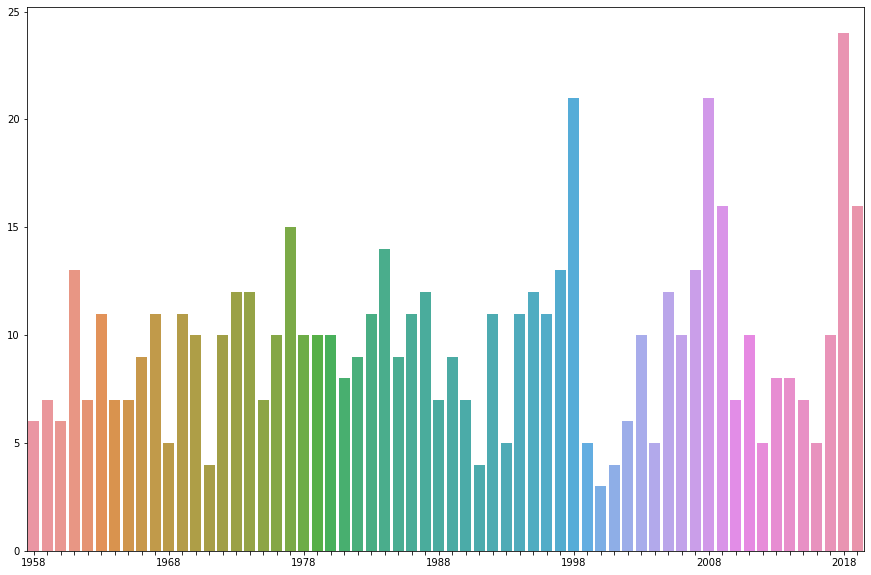

In [13]:
years = np.arange(1958, 2020)
year_counts = [0] * len(years)
for row_index, row in songs_sampled.iterrows():
    song_year = songs_sampled.at[row_index, 'Year']
    year_counts[song_year-1958] += 1

fig, ax = plt.subplots(figsize=(15,10))
ax = sns.barplot(years, year_counts)

counter = 0
for label in ax.get_xticklabels():
    if counter % 10 != 0:
        label.set_visible(False)
    counter += 1

Looks like a good sample! Of course, it's not perfect, since there appear to be a few years that had quite a few more songs than others. This could be due to our dropping duplicate rows, if some spectacular songs stayed on the charts across multiple years. Either way, though, this works for what we want to do.

#### Getting Song Lyrics with LyricsGenius

To get the song lyrics we need, we could manually find each song on a website like Genius and scrape the lyrics... but we can be smarter about it. Genius has a [free API](https://docs.genius.com/) (that requires project registration) that allows you to query for lyrics!  We can take this one step further, with a package designed by John Miller called [LyricsGenius](https://github.com/johnwmillr/LyricsGenius). This package enables us to query the Genius API much more intuitively, making this task much easier.

Before using it for our purposes, let's take a look at how it works. **(NEED TO FIND A WAY TO HIDE API TOKEN BEFORE POSTING)**

In [14]:
genius = lyricsgenius.Genius('EJqlckWu_h-lDQ8fVR8XOHpKJuEPV1liGiavTav-Y5y1QC1OrUy6AqYFD-VHl8YC')
genius.remove_section_headers = True

The above code sets up our LyricsGenius object with a developer token (that can be generated for a new project [here](https://docs.genius.com/)) and allows us to get the pure text of the lyrics without any headers like [Chorus]. If we wanted to only analyze the choruses of our songs, we could leave that setting disabled.

To actually get the song lyrics, we can just pass in a song and artist name into the LyricsGenius object.

In [15]:
example = genius.search_song('Never Gonna Give You Up', 'Rick Astley')

Searching for "Never Gonna Give You Up" by Rick Astley...
Done.


This either returns a NoneType if not found, or a Song object, from which we can get the lyrics:

In [16]:
print(example.lyrics)

We're no strangers to love
You know the rules and so do I
A full commitment's what I'm thinking of
You wouldn't get this from any other guy

I just wanna tell you how I'm feeling
Gotta make you understand

Never gonna give you up
Never gonna let you down
Never gonna run around and desert you
Never gonna make you cry
Never gonna say goodbye
Never gonna tell a lie and hurt you

We've known each other for so long
Your heart's been aching but you're too shy to say it
Inside we both know what's been going on
We know the game and we're gonna play it

And if you ask me how I'm feeling
Don't tell me you're too blind to see

Never gonna give you up
Never gonna let you down
Never gonna run around and desert you
Never gonna make you cry
Never gonna say goodbye
Never gonna tell a lie and hurt you
Never gonna give you up
Never gonna let you down
Never gonna run around and desert you
Never gonna make you cry
Never gonna say goodbye
Never gonna tell a lie and hurt you

(Ooh, give you up)
(Ooh, give y

Perfect! Let's throw this in a function that we can use for our data later on.

In [17]:
def get_lyrics(artist, song):
    temp = genius.search_song(song, artist)
    if temp is not None:
        return temp.lyrics
    else:
        return None

#### Calculating Polarity Scores with VADER

There are many packages to perform sentiment analysis, but I'll be using VADER, found [here.](https://github.com/cjhutto/vaderSentiment) As stated on the webpage, this tool is "specifically attuned to sentiments expressed in social media", which includes emojis, typed emoticons, and slang. The emojis aren't of much use to us, but the flexibility with slang is what made it particularly attractive for this project. VADER is also different to other tools because it doesn't require training data. Instead, its sentiment lexicon is fully human-curated, and what makes me call this EDA instead of ML. 

Similarly to LyricsGenius, we start with making a SentimentIntensityAnalyzer. Then, we can call the polarity_scores() method on it to get our analyzed sentiment scores. VADER places emphasis on keeping the original text, rather than tokenizing, so that's what we'll do. Let's test this on our earlier lyrics.

In [18]:
analyzer = SentimentIntensityAnalyzer();
analyzer.polarity_scores(example.lyrics)

{'neg': 0.152, 'neu': 0.816, 'pos': 0.032, 'compound': -0.9951}

We can see that VADER returns a dict of 4 values: 'neg', 'neu', 'pos', and 'compound'. The first three correspond to the negative, neutral, and positive scores, respectively. The last score is a combination of the other scores, which is then normalized to the range [-1, 1], representing "extremely negative" to "extremely positive". More information about exactly how the compound score is calculated in the link above.

#### Putting It Together!
Now, we can define a function that will first get our lyrics using LyricsGenius, and then analyze it using VADER. We'll use it to add columns to our sampled_songs DataFrame. Note that we return NaN values if the lyric query failed.

In [19]:
def get_sen_scores(artist, song):
    lyrics = get_lyrics(artist, song)
    if lyrics is not None:
        scores = analyzer.polarity_scores(lyrics)
        return scores['pos'], scores['neu'], scores['neg'], scores['compound']
    else:
        return np.nan, np.nan, np.nan, np.nan

Then, we want to add year and decade columns to our sampled songs, to allow for ease of plotting later on:

In [20]:
years = songs_sampled['Year']
decades = []
for year in years:
    if year < 1970:
        decades.append('1958-1969')
    elif (year >= 1970 and year < 1980):
        decades.append('1970-1979')
    elif (year >= 1980 and year < 1990):
        decades.append('1980-1989')
    elif (year >= 1990 and year < 2000):
        decades.append('1990-1999')
    elif (year >= 2000 and year < 2010):
        decades.append('2000-2010')
    else:
        decades.append('2010-2019')

The calculation of the polarity scores is mundane, computationally heavy, and takes a lot of time, so for simplicity's sake, we'll run through what the output would look like for the top three rows of the dataframe. Please just trust that we ran all of it on our own time, and saved you the trouble of seeing all the output.

In [21]:
sample_pos = []
sample_neu = []
sample_neg = []
sample_comp = []
for row_index, row in songs_sampled[0:3].iterrows():
    song = songs_sampled.at[row_index, 'Song']
    artist = songs_sampled.at[row_index, 'Performer']
    pos, neu, neg, comp = get_sen_scores(artist, song)
    sample_pos.append(pos)
    sample_neu.append(neu)
    sample_neg.append(neg)
    sample_comp.append(comp)
    
sample_polarity_vals = {'Pos_Score': sample_pos, 'Neu_Score': sample_neu, \
                        'Neg_Score': sample_neg, 'Comp_Score': sample_comp}
sample_polarity_scores = pd.DataFrame(data=sample_polarity_vals)
sample_polarity_scores.head(3)

Searching for "Smoke Gets In Your Eyes" by The Platters...
Done.
Searching for "Telstar" by The Tornadoes...
Done.
Searching for "Stranger On The Shore" by Mr. Acker Bilk...
Done.


,Pos_Score,Neu_Score,Neg_Score,Comp_Score
0,0.283,0.599,0.118,0.9792
1,0.149,0.788,0.063,0.8934
2,0.122,0.797,0.081,1.0000


So we ran that for 600 lines (battling name resolution and connection errors along the way) and downloaded our results as a CSV file called "Polarity Scores" for easy access. We'll then add a "Year" and "Decade" column for ease of plotting.

In [22]:
polarity_scores = pd.read_csv('Polarity Scores.csv')
polarity_scores['Decade'] = decades
polarity_scores['Year'] = songs_sampled['Year']
polarity_scores.sort_values(by='Year', inplace=True)
polarity_scores.reset_index(inplace=True)
polarity_scores.drop('index', axis=1, inplace=True)
polarity_scores.head(3)

,Pos_Score,Neu_Score,Neg_Score,Comp_Score,Decade,Year
0,0.191,0.731,0.077,0.9888,1958-1969,1958
1,0.346,0.644,0.010,0.9971,1958-1969,1958
2,0.048,0.938,0.014,0.6479,1958-1969,1958


Given the nature of our data, a violin plot intuitively makes sense, so let's plot the distribution of compound scores across each decade.

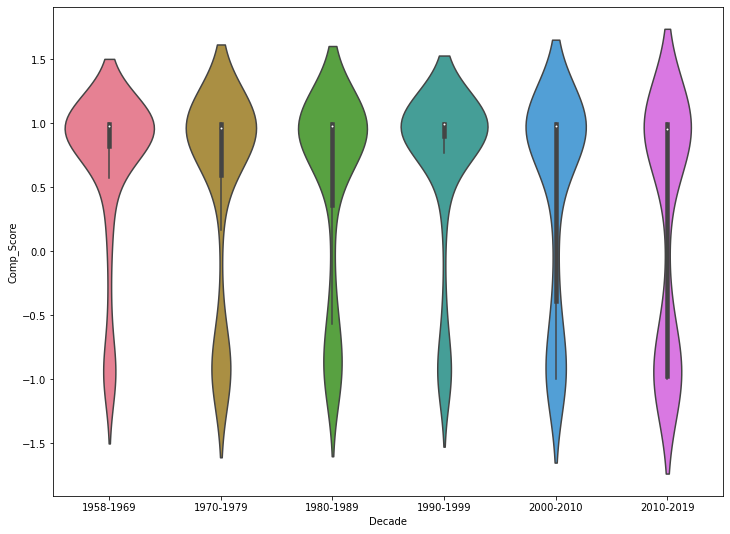

In [23]:
fig, ax = plt.subplots(figsize=(12, 9))
ax = sns.violinplot(x='Decade', y='Comp_Score', data=polarity_scores, palette="husl")

At first glance, it looks like the plots are quite similar across each decade all with high medians very close to 1. However, we can see that the amount of negative scores increases over time. We can see this in the increasing thickness of the bottom half of the violins. To take a closer look at this, we could plot the mean over time, and fit a regression line to it.

Let's first calculate the  mean score for each year, and then plot!

In [24]:
polarity_types = ['Pos_Score', 'Neu_Score', 'Neg_Score', 'Comp_Score']
polarity_averages = polarity_scores.groupby(["Year"])[polarity_types].mean()
polarity_averages.reset_index(inplace=True)
polarity_averages.head(3)

,Year,Pos_Score,Neu_Score,Neg_Score,Comp_Score
0,1958,0.259333,0.710667,0.029833,0.933233
1,1959,0.129000,0.798000,0.073000,0.290071
2,1960,0.245500,0.675167,0.079333,0.561033


comp_score = -0.0063*year + 12.9972


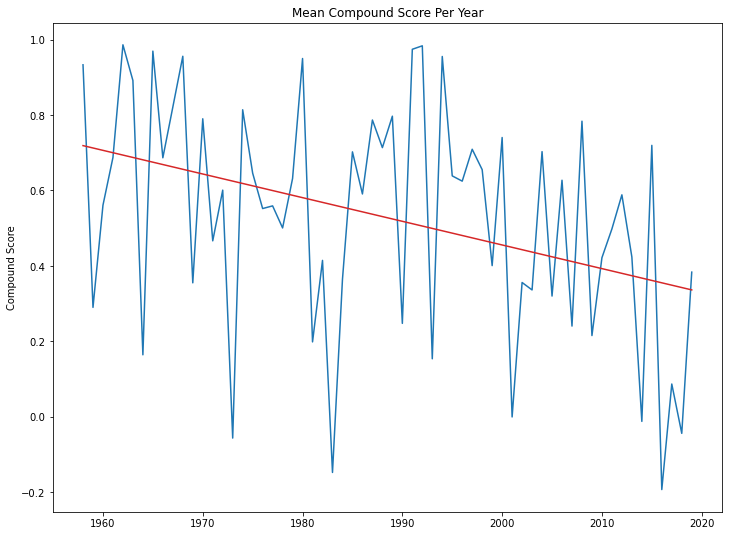

In [25]:
fig, ax = plt.subplots(figsize=(12, 9))

x = polarity_averages['Year']
y = polarity_averages['Comp_Score']

# Plot polarity score means per year
ax.plot(x, y,  'tab:blue')
ax.set_title("Mean Compound Score Per Year")
ax.set(ylabel='Compound Score')

m, b = np.polyfit(x, y, 1)
ax.plot(x, (m*x + b), 'tab:red')
eq = ('comp_score = {}*year + {}').format(m.round(4), b.round(4))
print(eq)

Looking at this plot, we can see that songs are becoming more negative over time. Is it possible that the acoustic features have anything to do with this observation? Let's revisit the acoustic feature plots we made earlier.

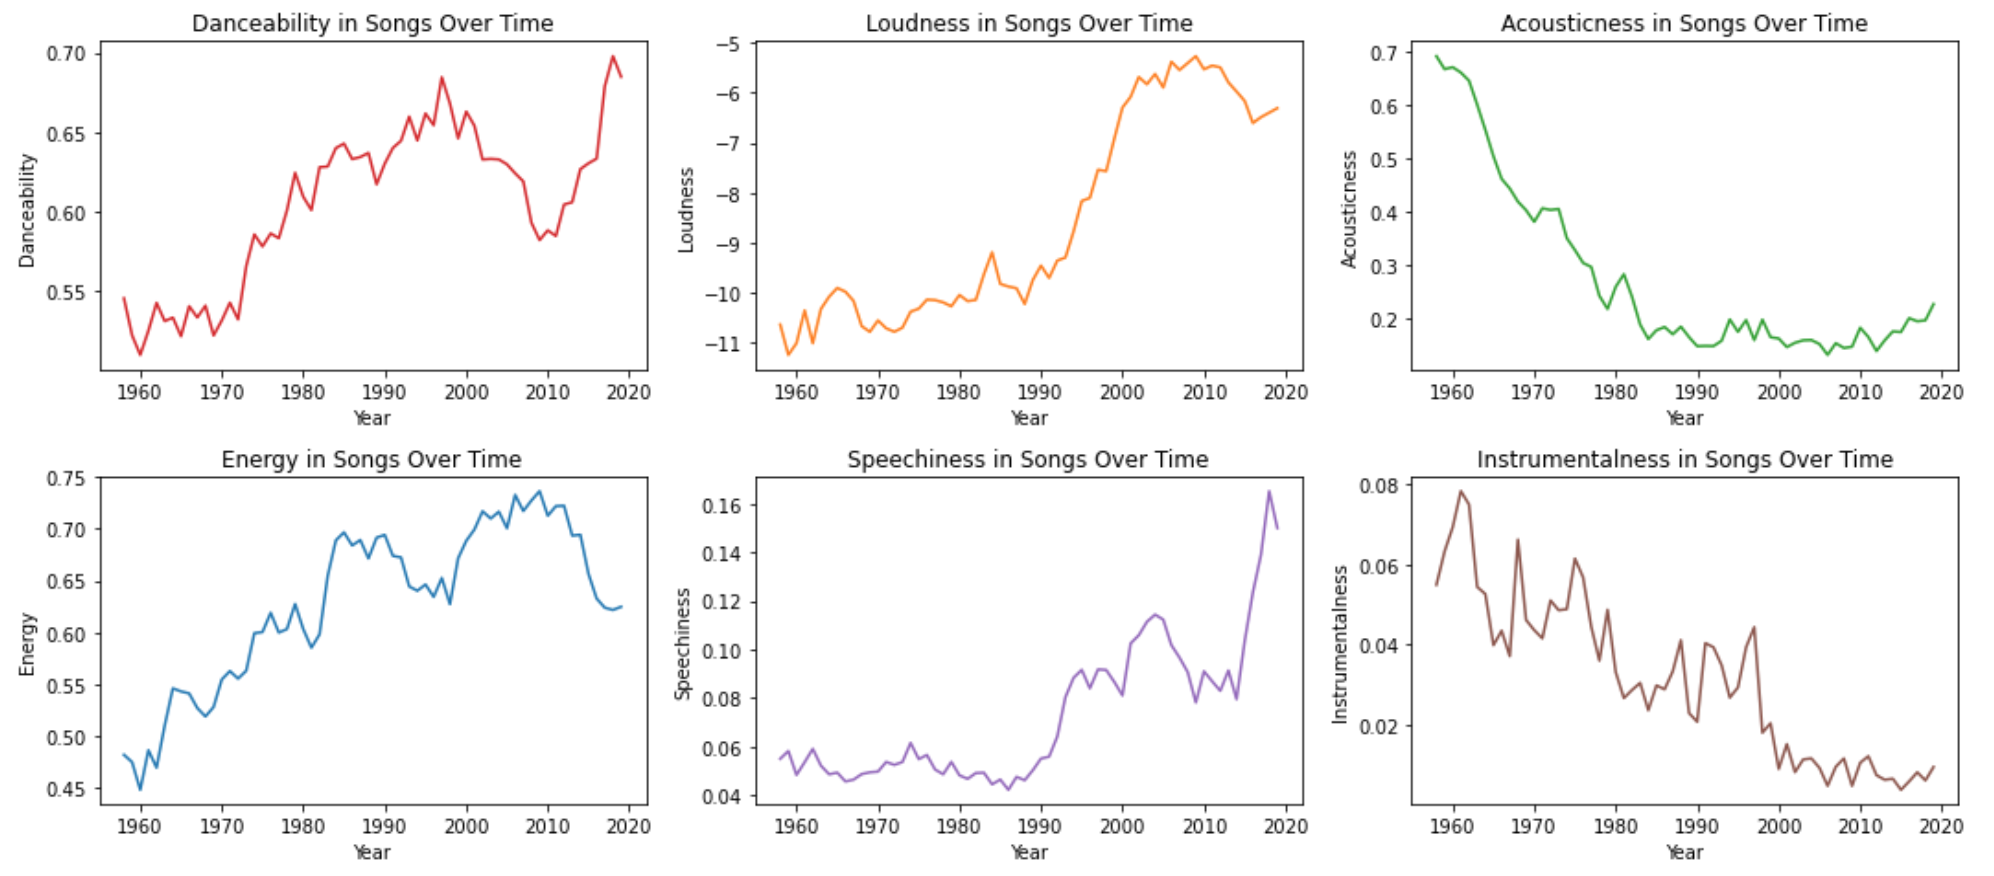

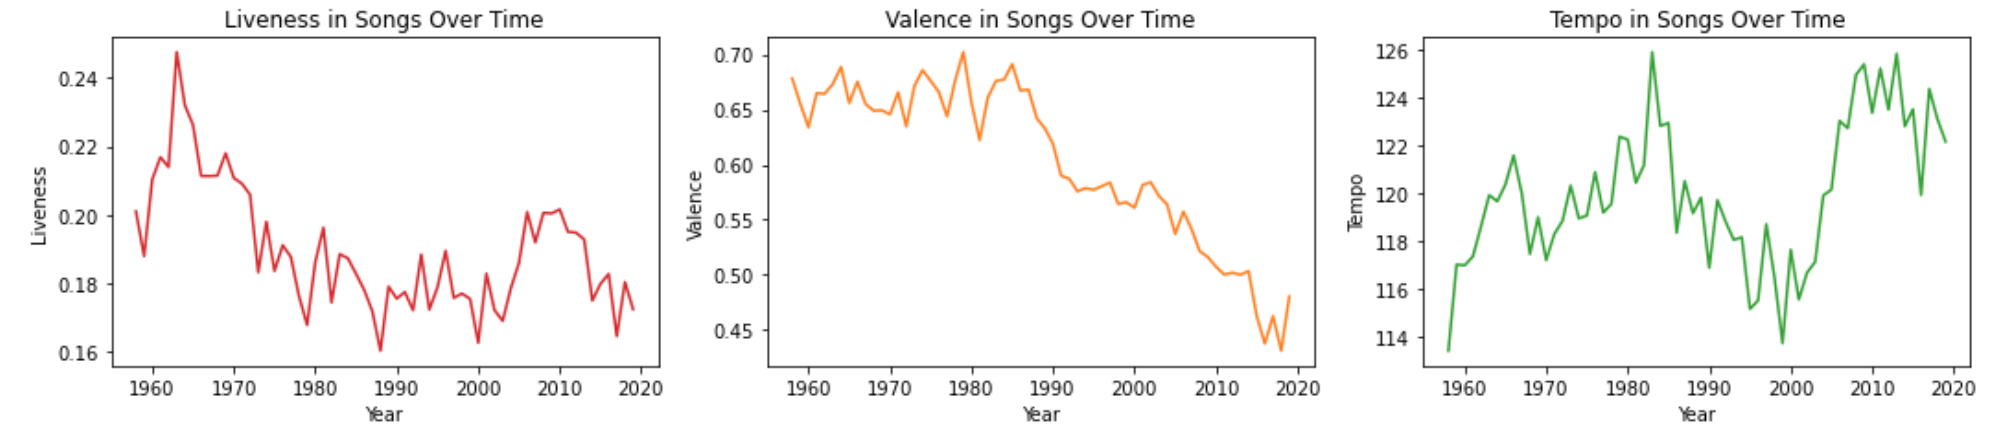

Interestingly, features like danceability, speechiness, and loudness have been increasing since the 1960s while intrumentalness and acousticness have been decreasing. Maybe there is a relationship between acoustic features and the polarity scores of songs. Could it be that acoustic songs are more positive while speechy songs are more negative?

Let's look into it!

## 4. Machine Learning: Predicting the Patterns

We want to predict the compound score (dependent variables) based on 9 acoustic features (independed variables): danceability, energy, loudness, speechiness, acousticness, intrumentalness, liveness, valence, and tempo 
buutt we end up with high multicolinearity cuz the independent variables are too correlated, so we would have to create interaction terms. Doing that for 9-10 variables would be insane, we would end up with too many interaction terms than would be feasible so lets pick a few acoustic features whose plots over time we found interesting.


We notice that the valence of songs is going down over time. According to Spotify's doccumentation for acoustic features, valence is defined as the describing the musical positiveness of a track. So if a song has high valence it **(sounds)** more positive and happy whereas a low valence has a sadder sound. Interesting! In our sentiment analysis, we found that **(lyrics)** are getting more negative over time. Do negative sounding songs also have negative lyrics? Let's examine this further with some regression models.

Downside: We do not know if Spotify's calcuation of valence included an analysis of the lyrics or just an analysis of the sounds. 

- If we have the lyrics and acoustic features of a song, can we predict what kind of lyrics it has?

## 5. Just For Fun

### 5A. Visualizing Lyrics

Word clouds are a really cool way of visualizing text! All of the unique words in a text will be added to a bubble, with higher frequency words taking up more space in the bubble and low frequency words taking up less space. We have shown in our tutorial that music has been changing over time, whether it be through its acoustic features, lyrics, or popularity. So far, we have primarily been visualizing numeric data, so let's take some time to visualize the actual song lyrics we have scraped! To do this, we are going to use pythons [wordcloud](https://pypi.org/project/wordcloud/) library. But there are also free online [generators](https://www.wordclouds.com/) available!



We will start off by storing the lyrics of popular songs for each decade into variables. Here, we are going to reuse our database of sampled songs which already has each of the decades separated chronologically! The code used to store scraped lyrics is very similar to the code we used to calculate the polarity scores of lyrics. We went through 600 rows of the cloud dataframe by splitting them into 100 row sections where every 100 rows represents a decade. Similarly to our sentiment analysis, we've included a snippet of the code to reduce redundancy and ran everything separately!

In [31]:
# populate sample lyrics variable 
sample_lyrics = ""
for row_index, row in songs_sampled[0:3].iterrows():
    song = songs_sampled.at[row_index, 'Song']
    artist = songs_sampled.at[row_index, 'Performer']
    temp = get_lyrics(artist, song)
    if (temp is not None):
        sample_lyrics += temp     

Searching for "Smoke Gets In Your Eyes" by The Platters...
Done.
Searching for "Telstar" by The Tornadoes...
Done.
Searching for "Stranger On The Shore" by Mr. Acker Bilk...
Done.


Now that we have all of our lyrics stored, we can start making our word clouds! We generated all of our clouds and saved them as pngs so that we could examine them side by side (and avoid redundant code). Here is an example of how to make a cloud.

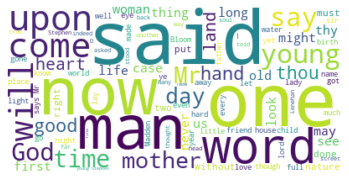

In [32]:
# Generate Word Cloud 
text = sample_lyrics

# Create and generate a word cloud image
wordcloud = WordCloud(max_words=100, background_color="white").generate(text)

# Display the generated image
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### 5B. Word Clouds!!! 

Finally, we can take a look at word clouds of popular song lyrics from each decade!

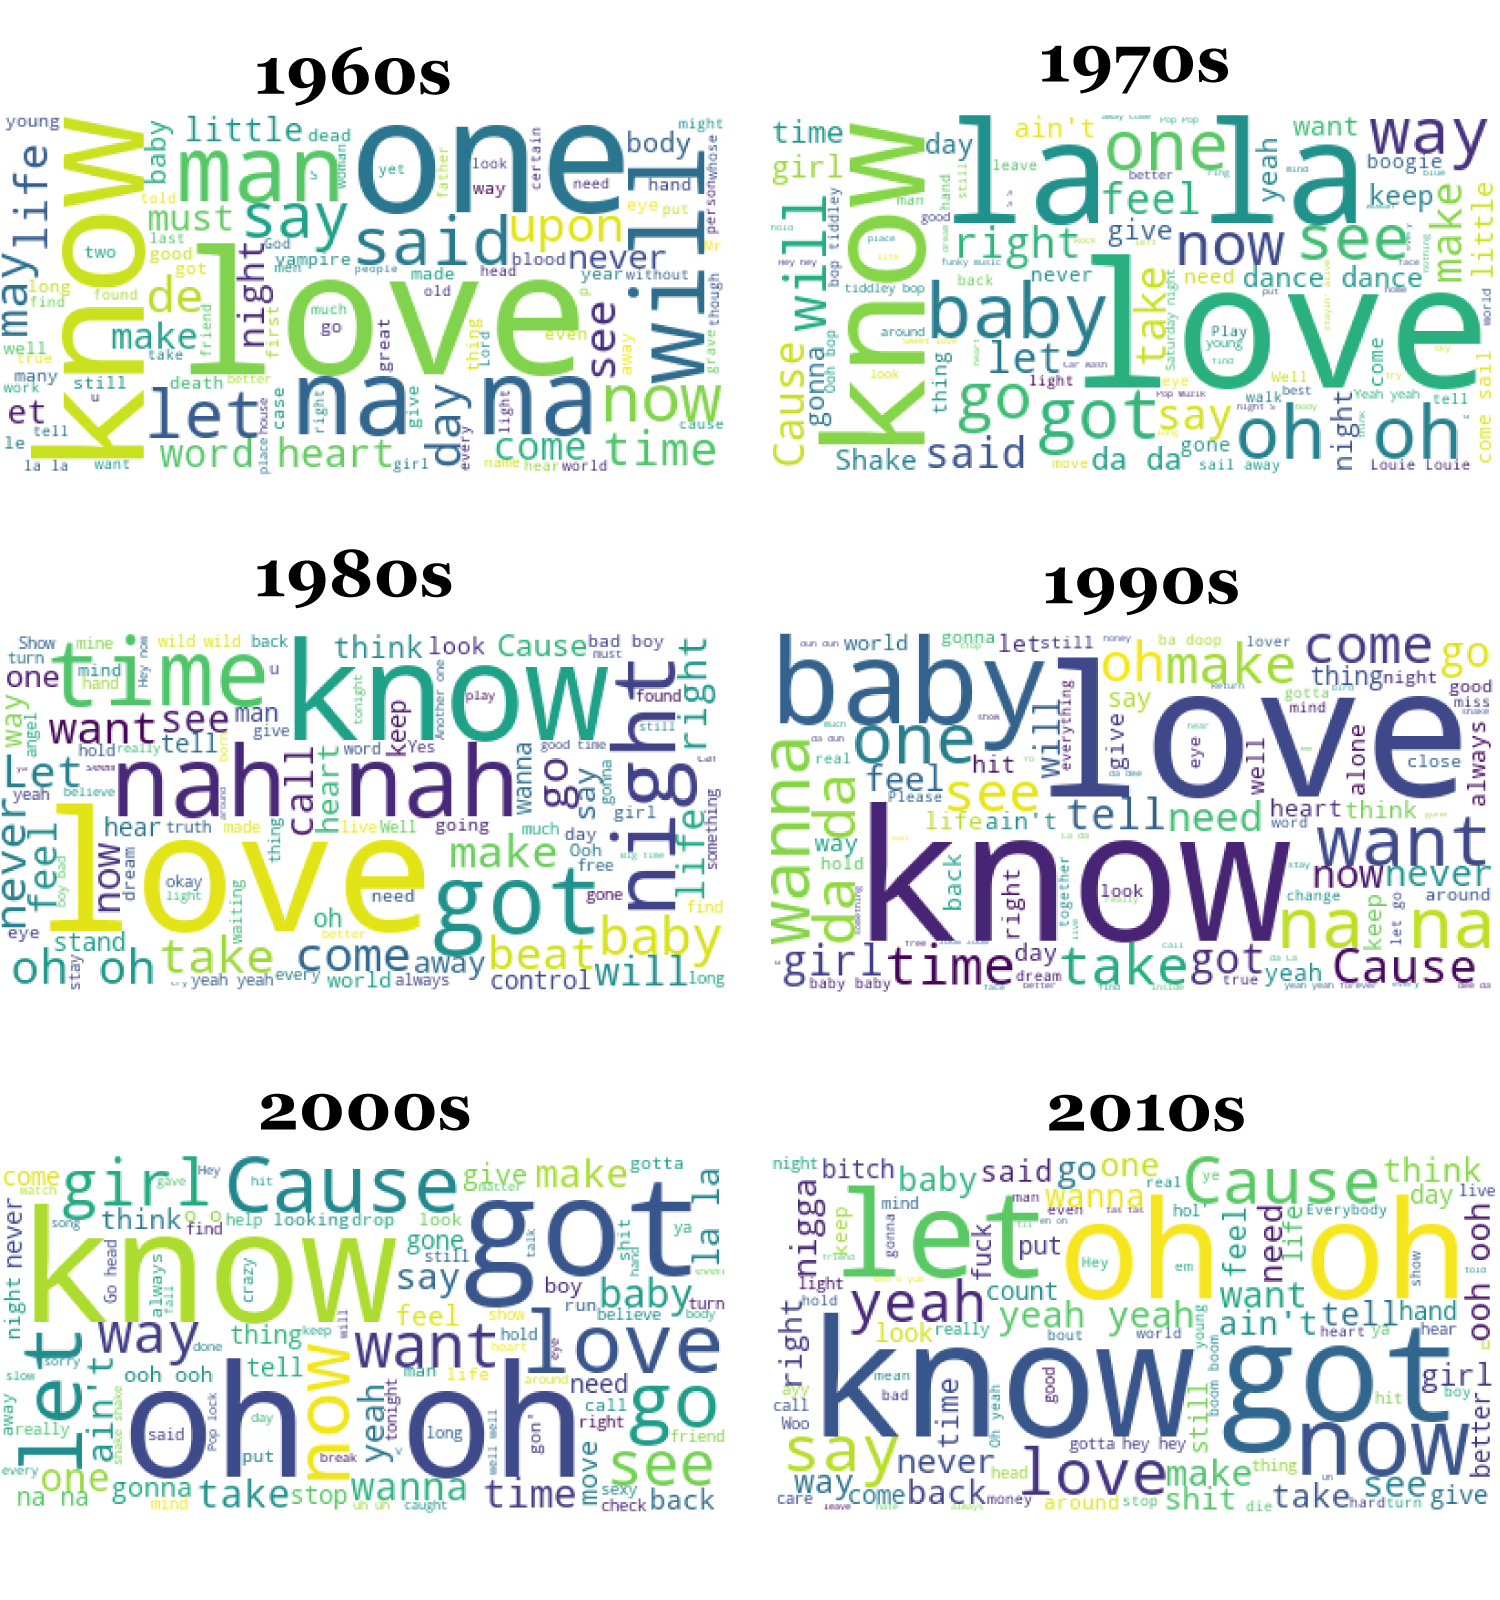

Wow. Looking at the 2010s compared to 1960s, there are definitly way more negative words (shit, never, bitch, fuck, bad, ain't). Interestingly, the word "love" became smaller and less used in songs as the decades went on!! Words like "know", "got", and "oh" are also unexpectedly common in songs across all of the decades. 

## 6. Insights and Conclusions

In [ ]:
# def get_artist(artist_string):
#     if ',' in artist_string: # must be three or more artists
#         re.match((.*))
#     elif '&' in artist_string: # must be two artists
#     else: # only one artist
#         return artist_string

- need to take out &